# Jay and Kyle:  Film Industry Consultants

In [4]:
#Importing modules
import pandas as pd
import mysql.connector
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

In [5]:
# Magic Command
%matplotlib inline  
# for now, will change to qt for interactive chart

In [8]:
# Establishing connection to mysql database
con = mysql.connector.connect(user = 'hbs-student', password = 'super-secure-password?',
                              host = 'hbs-ds-060120.c1doesqrid0e.us-east-1.rds.amazonaws.com',
                              database = 'movies')

## Question #1:  Which genre should we start with?

In [10]:
#Set the mysql query 
query = """
SELECT itb.*, bmg.*, tmb.release_date, tmb.worldwide_gross, tmb.production_budget
FROM movies.imdb_title_basics itb
JOIN movies.bom_movie_gross bmg
ON itb.primary_title = bmg.title
JOIN movies.tn_movie_budgets tmb
ON tmb.movie = bmg.title
"""
# Reading query output into df
df = pd.read_sql_query(query, con)

In [11]:
# Data cleaning and melt to get 'genre' string data into individual row entries.
df_genre = df.genres.apply(lambda x: x.split(',')).apply(pd.Series)\
            .merge(df, left_index = True, right_index = True)\
            .drop(["genres", 'primary_title', 'title'], axis = 1)\
            .melt(id_vars = ['tconst', 'original_title', 'start_year', 'runtime_minutes', 'studio',\
                 'domestic_gross', 'foreign_gross', 'year', 'release_date', 'worldwide_gross', 'production_budget'],\
                  value_name = "genre")\
            .dropna(subset=['genre'])\
            .sort_values(by = 'genre')

# Split string on ',' into list and creating dataframe
# Merging new data fram with original df
# Dropping redunant columns
# Melting new genre columns into individual row entries
# Dropping rows with null 'genre' column 
# Sorting by genre

In [12]:
# Reformatting columns with string variables to int
dollar_string = ['worldwide_gross', 'production_budget']

for string in dollar_string:
    df_genre[string] = df_genre[string].str.replace("$", "").str.replace(',','').astype(int)

In [13]:
# Caluculating new columns ('roi' = Return on Investment)
df_genre['roi'] = (df_genre.worldwide_gross - df_genre.production_budget)/df_genre.production_budget

In [14]:
# Filtering out movies with WW_Gross less than $1M and production budget of > $1M
df_genre_f = df_genre.loc[(df_genre['worldwide_gross'] > 1000000) & (df_genre['production_budget'] > 1000000)]

In [15]:
# Dropping non-null, but uncategorized genre movies
df_genre_f = df_genre_f.drop(df_genre_f.loc[df_genre_f['genre'] == ''].index)

Text(0.5, 1.0, 'ROI per Genre')

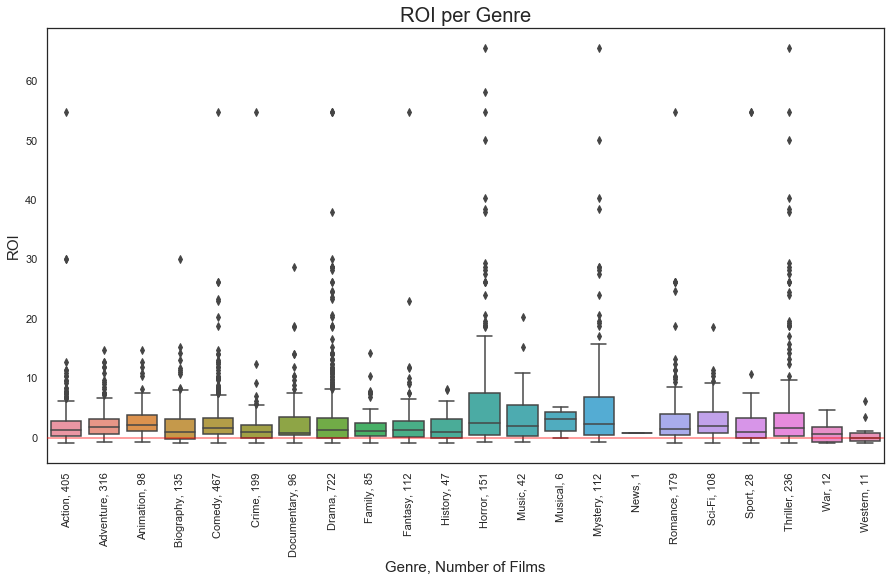

In [62]:
# Setting up a boxplot for ROI by Genre 
plt.figure(figsize = (15,8))
ax = sns.boxplot(x = "genre", y = "roi", data = df_genre_f)

# Setting xtick labels to include genre and movie count
xt = []
genre_counts = df_genre_f.groupby('genre').count()['tconst']
genre_unique = df_genre_f.genre.unique()
for a in genre_unique:
    xt.append(f'{a}, {genre_counts[a]}')

# Finishing the plot
ax.axhline(y=0, color='red', zorder =100, alpha = .5)
ax.set_xticklabels(xt, rotation=90, horizontalalignment='center')
plt.xlabel('Genre, Number of Films', fontsize=15)
plt.ylabel('ROI', fontsize=15)
plt.title('ROI per Genre', fontsize=20)

So, it looks 'Horror' is an appealing genre.  Let's take a look at normalized distribution plots to get a better sense of the probability of 'hitting a home run'. 

In [27]:
# Filtering out outliers for plotting purposes
df_genre_f_dg =  df_genre_f.loc[(df_genre['roi'] < 20)]

In [33]:
# Dropping genres with fewer than 20 entries in order to make KDE plots useful
genre_drop_list = ['News', 'War', 'Musical', 'Western']
for gen in genre_drop_list:
    df_genre_f_dg = df_genre_f_dg.drop(df_genre_f_dg[df_genre_f_dg['genre'] == gen].index)


Text(0.5, 0, 'ROI')

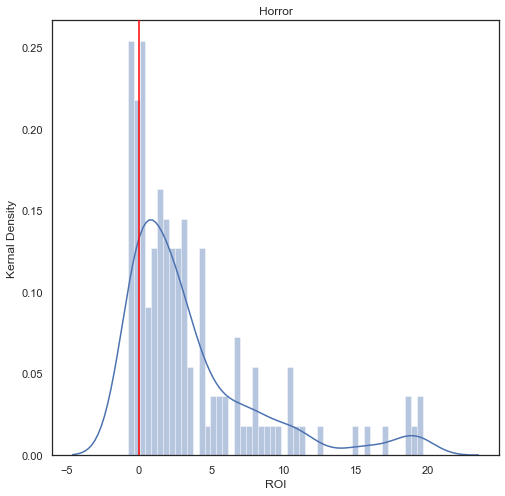

In [54]:
# Plotting KDE and Normalized Histograms for specified genre

# Building histogram data for each genre
genre_list = df_genre_f_dg.genre.unique()
total_dict = {}
for genre_type in genre_list: 
    total_dict[genre_type] = df_genre_f_dg.loc[df_genre_f_dg.genre == genre_type][['tconst', 'roi', 'genre']]

# Genre Choice Set up
values = list(range(0,len(genre_list)))
dictionary = dict(zip(genre_list, values))

#Genre choice : 'Action' 'Adventure' 'Animation' 'Biography' 'Comedy' 'Crime''Documentary' 'Drama' 'Family' 'Fantasy' 'History' 
                #'Horror' 'Music' 'Mystery' 'Romance' 'Sci-Fi' 'Sport' 'Thriller'

genre_choice = 'Horror'

#Pulling specified genre data
indexer = dictionary[genre_choice]   
g = total_dict[genre_list[indexer]]['roi']

#Finish plotting normalized histogram and KDE
y=g.tolist()
new_fig = plt.figure(figsize=(8,8))
ax = sns.distplot(y, bins =50, kde=1)
ax.axvline(x=0,ymin=0, ymax=1, color='red', zorder =100, alpha = 1)
plt.title(genre_list[indexer])
plt.ylabel('Kernal Density')
plt.xlabel('ROI')

Text(0.5, 8.959999999999773, 'ROI')

<Figure size 1440x576 with 0 Axes>

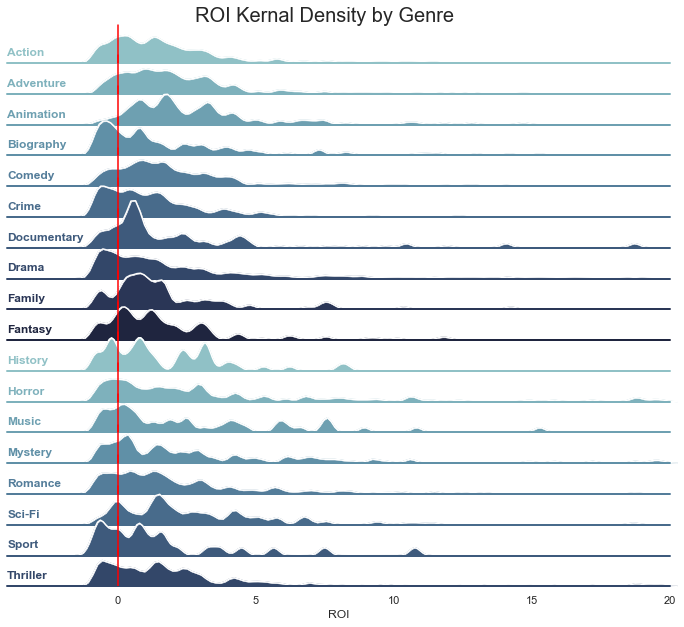

In [60]:
# It is helpful to plot all the genre KDEs on top of each other to compare odds of making a high ROI movie
# Ridge plot documentation from: https://seaborn.pydata.org/examples/kde_ridgeplot
plotdf = df_genre_f_dg[['genre', 'roi']]
plotdf = plotdf.reset_index()

plt.figure(figsize=(20,8))
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

#Set palette and FacetGrid, from SNS documentation
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(plotdf, row="genre", hue="genre", aspect=20, height=.5, palette=pal)

# Draw the densities in a few steps, from SNS documentation
g.map(sns.kdeplot, "roi", clip_on=False, shade=True, alpha=1, lw=1, bw=.2)
g.map(sns.kdeplot, "roi", clip_on=False, color="w", lw=1.5, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)
g.map(plt.axvline, x=0,ymin=-.10, ymax=.75, color='red', zorder =100, alpha = 1)

# Define and use a simple function to label the plot in axes coordinates, from SNS documentation
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "genre")

# Set the subplots to overlap, from SNS documentation
g.fig.subplots_adjust(hspace=-.4)
g.set(ylim=(0, .5))
g.set(xlim=(-4, 20))

# Remove axes details that don't play well with overlap, from SNS documentation
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)
plt.text(7.5, 5.5, 'ROI Kernal Density by Genre',
         horizontalalignment='center',
         fontsize=20)
plt.xlabel('ROI')



## Question 2: What is ideal crew to assembly?

In [6]:
# Re-establishing connection to mysql database
con = mysql.connector.connect(user = 'hbs-student', password = 'super-secure-password?',
                              host = 'hbs-ds-060120.c1doesqrid0e.us-east-1.rds.amazonaws.com',
                              database = 'movies')

In [7]:
# New SQL query to join movies and names tables
query = """
SELECT itb.*, bmg.*, tmb.release_date, tmb.worldwide_gross,
    tmb.production_budget, itc.directors, itc.writers, itp.job, itp.characters, itp.category as category_itp, inb.*
FROM movies.imdb_title_basics itb
JOIN movies.bom_movie_gross bmg
ON itb.primary_title = bmg.title
JOIN movies.tn_movie_budgets tmb
ON tmb.movie = bmg.title
Join movies.imdb_title_crew itc
ON itc.tconst = itb.tconst
Join movies.imdb_title_principals itp
ON itp.tconst = itc.tconst
Join movies.imdb_name_basics inb
ON inb.nconst = itp.nconst
"""
df_crew = pd.read_sql_query(query, con)

In [8]:
# Reformatting columns with string variables to int
dollar_string = ['worldwide_gross', 'production_budget']

for string in dollar_string:
    df_crew[string] = df_crew[string].str.replace("$", "").str.replace(',','').astype(int)

In [9]:
# Caluculating new columns ('roi' = Return on Investment)
df_crew['roi'] = (df_crew.worldwide_gross - df_crew.production_budget)/df_crew.production_budget

In [14]:
def findcrew_table(data, job_role, movie_count):
    # Filter for job Role
    if len(job_role) == 1:
        df_tcrew = df_crew.loc[(df_crew['category_itp'] == str(job_role[0]).lower())]
    if len(job_role) == 2:
        df_tcrew = df_crew.loc[(df_crew['category_itp'] == job_role[0]) | (df_crew['category_itp'] == job_role[1]) ]
    #Group by  names
    tcrewCount_dict = df_tcrew.groupby(['primary_name']).count()['tconst'].to_dict()
    # New column for movie count
    df_tcrew['movie_count'] = df_tcrew['primary_name'].map(tcrewCount_dict)
    # Filtering based on minimum movie count
    df_stars= df_tcrew.loc[df_tcrew.movie_count >=movie_count]
    # setting up the scatter plot
    df_stars_scatter = df_stars.groupby(['primary_name']).mean().sort_values(by = ['domestic_gross'], ascending = False)\
                                    [['worldwide_gross', 'production_budget', 'movie_count']]
    # Group by names
    df_stars_select = df_stars.groupby('primary_name').mean()
    # Initializing the crew table 
    df_stars_table = pd.DataFrame()
    # Creating the table 
    df_stars_table['Short List: Indy Film'] = df_stars_select.loc[df_stars_select.production_budget < 20000000]\
                    .sort_values(by = 'roi', ascending = False).reset_index()['primary_name'].head(10)
    df_stars_table['Short List: Mainstream'] = df_stars_select.loc[(df_stars_select.production_budget > 20000000)\
                    & (df_stars_select.production_budget < 100000000)].sort_values(by = 'roi', ascending = False)\
                    .reset_index()['primary_name'].head(10)
    df_stars_table['Short List: Blockbuster '] = df_stars_select.loc[df_stars_select.production_budget > 100000000]\
                    .sort_values(by = 'roi', ascending = False).reset_index()['primary_name'].head(10)
    print(f'{job_role}')
    return df_stars_table

In [17]:
print(findcrew_table(df_crew, ['director'], 3))
print(findcrew_table(df_crew, ['actor', 'actress'], 3))
print(findcrew_table(df_crew, ['writer'], 3))
print(findcrew_table(df_crew, ['composer'], 3))

['director']
  Short List: Indy Film Short List: Mainstream Short List: Blockbuster 
0        Ariel Schulman              James Wan             Bryan Singer
1           Henry Joost     M. Night Shyamalan            Anthony Russo
2        James DeMonaco       Scott Derrickson                Joe Russo
3    Christopher Landon        Damien Chazelle              Michael Bay
4        Michael Tiddes          Pierre Coffin         Francis Lawrence
5     Richard Linklater           Chris Renaud               Rich Moore
6      Derek Cianfrance           Ryan Coogler        Christopher Nolan
7              Eli Roth       Darren Aronofsky                Marc Webb
8           John Madden            Jake Kasdan            Mike Mitchell
9          J.C. Chandor      Steven Soderbergh          Carlos Saldanha
['actor', 'actress']
  Short List: Indy Film Short List: Mainstream Short List: Blockbuster 
0       Anya Taylor-Joy        Jesse McCartney             Will Poulter
1           Ethan Hawke       

C:\Users\kyled\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\kyled\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\kyled\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

In [70]:
# Filter for Actors and Actresses
df_actors = df_crew.loc[(df_crew['category_itp'] == 'actor') | (df_crew['category_itp'] == 'actress') ]

In [71]:
#Group by Actors names
actorCount_dict = df_actors.groupby(['primary_name']).count()['tconst'].to_dict()

In [74]:
# New column for movie count
df_actors['movie_count'] = df_actors['primary_name'].map(actorCount_dict)

C:\Users\kyled\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [372]:

df_stars= df_actors.loc[df_actors.movie_count >=3]
df_stars_scatter = df_stars.groupby(['primary_name']).mean().sort_values(by = ['domestic_gross'], ascending = False)\
                                    [['worldwide_gross', 'production_budget', 'movie_count']]
df_stars_scatter

,start_year,runtime_minutes,domestic_gross,foreign_gross,year,worldwide_gross,production_budget,birth_year,death_year,roi,movie_count
primary_name,,,,,,,,,,,
Robert Downey Jr.,2013.777778,132.111111,3.262111e+08,4.291111e+08,2013.777778,9.034949e+08,1.850667e+08,1965.0,NaN,3.384089,9.0
Gal Gadot,2017.333333,124.333333,2.809000e+08,3.887667e+08,2017.333333,6.671208e+08,2.083333e+08,1985.0,NaN,2.552204,3.0
Ian McKellen,2013.250000,151.500000,2.626000e+08,6.582250e+08,2013.250000,9.177027e+08,2.375000e+08,1939.0,NaN,2.857777,4.0
Bryce Dallas Howard,2013.000000,125.400000,2.614800e+08,2.030800e+08,2013.000000,6.635485e+08,9.360000e+07,1981.0,NaN,5.242991,5.0
Chris Pratt,2014.000000,122.714286,2.594571e+08,2.321286e+08,2014.000000,6.357140e+08,1.027857e+08,1979.0,NaN,4.048263,7.0
...,...,...,...,...,...,...,...,...,...,...,...
Tilda Swinton,2014.000000,130.000000,2.933333e+06,3.063333e+07,2014.333333,3.528993e+07,2.233333e+07,1960.0,NaN,0.363792,3.0
Brit Marling,2012.200000,101.200000,2.448800e+06,9.385233e+06,2012.400000,8.448659e+06,3.962000e+06,1982.0,NaN,2.900221,5.0
Anton Yelchin,2012.750000,94.250000,1.907325e+06,3.318000e+06,2013.000000,3.287290e+06,7.812500e+06,1989.0,2016.0,3.007208,4.0


In [442]:
df_stars_select = df_stars.groupby('primary_name').mean()
df_stars_select
df_stars_table = pd.DataFrame()
df_stars_table['Short List: Indy Film'] = df_stars_select.loc[df_stars_select.production_budget < 10000000].sort_values(by = 'roi', ascending = False)\
                .reset_index()['primary_name'].head(10)
df_stars_table['Short List: Mainstream'] = df_stars_select.loc[(df_stars_select.production_budget > 10000000) & (df_stars_select.production_budget < 100000000)].sort_values(by = 'roi', ascending = False)\
                .reset_index()['primary_name'].head(10)
df_stars_table['Short List: Blockbuster '] = df_stars_select.loc[df_stars_select.production_budget > 100000000].sort_values(by = 'roi', ascending = False)\
                .reset_index()['primary_name'].head(10)
df_stars_table

,Short List: Indy Film,Short List: Mainstream,Short List: Blockbuster
0,Anya Taylor-Joy,Jesse McCartney,Will Poulter
1,Ethan Hawke,Patrick Wilson,Paul Walker
2,Mark Duplass,Rose Byrne,Stanley Tucci
3,Marlon Wayans,Lena Headey,Chris Pratt
4,James Ransone,Nat Wolff,Mark Ruffalo
5,Maggie Smith,Billy Burke,Irrfan Khan
6,John Hawkes,Catherine Keener,Don Cheadle
7,John Corbett,Alex Pettyfer,Vin Diesel
8,Joshua Leonard,Jamie Dornan,Robert Downey Jr.
9,Mary Steenburgen,Eloise Mumford,Samuel L. Jackson


Text(0, 0.5, 'Mean Worldwide Gross ($)')

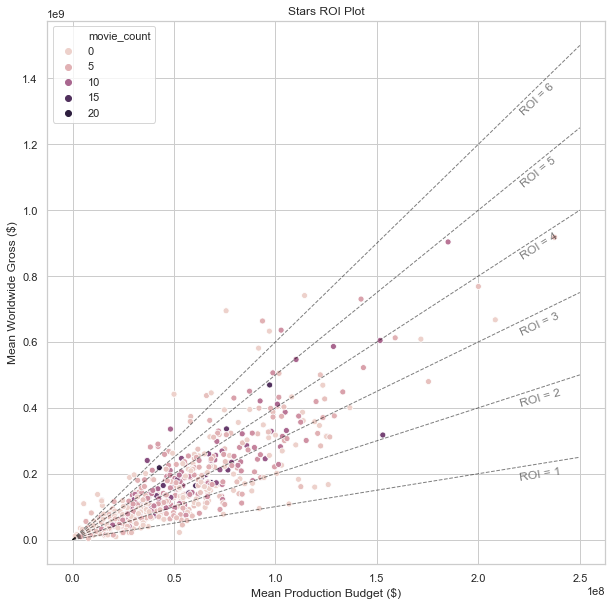

In [465]:
plt.figure(figsize =(10,10))
sns.set_style("whitegrid")
plotter = sns.scatterplot(x=df_stars_scatter.production_budget, y=df_stars_scatter.worldwide_gross, hue = df_stars_scatter.movie_count)
# plt.plot([0, 0], [200000000, 200000000], linewidth=2)
plt.plot(np.linspace(0,250000000,1000), np.linspace(0,250000000,1000) , 'black', ls='dashed', linewidth ='1', alpha =0.5)
plt.plot(np.linspace(0,250000000,1000),np.linspace(0,250000000,1000)*2 , 'black', ls='dashed', linewidth ='1', alpha =0.5)
plt.plot(np.linspace(0,250000000,1000),np.linspace(0,250000000,1000)*3 , 'black', ls='dashed', linewidth ='1', alpha =0.5)
plt.plot(np.linspace(0,250000000,1000),np.linspace(0,250000000,1000)*4 , 'black', ls='dashed', linewidth ='1', alpha =0.5)
plt.plot(np.linspace(0,250000000,1000),np.linspace(0,250000000,1000)*5 , 'black', ls='dashed', linewidth ='1', alpha =0.5)
plt.plot(np.linspace(0,250000000,1000),np.linspace(0,250000000,1000)*6 , 'black', ls='dashed', linewidth ='1', alpha =0.5)
plotter.text(220000000, 180000000, "ROI = 1", horizontalalignment='left', size='medium', color='black', weight='light', rotation = '9', alpha =0.5)
plotter.text(220000000, 405000000, "ROI = 2", horizontalalignment='left', size='medium', color='black', weight='light', rotation = '16', alpha =0.5)
plotter.text(220000000, 620000000, "ROI = 3", horizontalalignment='left', size='medium', color='black', weight='light', rotation = '25', alpha =0.5)
plotter.text(220000000, 850000000, "ROI = 4", horizontalalignment='left', size='medium', color='black', weight='light', rotation = '32', alpha =0.5)
plotter.text(220000000, 1070000000, "ROI = 5", horizontalalignment='left', size='medium', color='black', weight='light', rotation = '39', alpha =0.5)
plotter.text(220000000, 1290000000, "ROI = 6", horizontalalignment='left', size='medium', color='black', weight='light', rotation = '43', alpha =0.5)
plt.title('Stars ROI Plot')
plt.xlabel('Mean Production Budget ($)')
plt.ylabel('Mean Worldwide Gross ($)')
# grid = sns.JointGrid(iris.petal_length, iris.petal_width, space=0, size=6, ratio=50)
# grid.plot_joint(plt.scatter, color="g")
# plt.plot([0, 4], [1.5, 0], linewidth=2)

In [441]:
df_stars_select = df_stars.groupby('primary_name').mean()
df_stars_select
df_stars_table = pd.DataFrame()
df_stars_table['Short List: Indy Film'] = df_stars_select.loc[df_stars_select.production_budget < 10000000].sort_values(by = 'roi', ascending = False)\
                .reset_index()['primary_name'].head(10)
df_stars_table['Short List: Mainstream'] = df_stars_select.loc[(df_stars_select.production_budget > 10000000) & (df_stars_select.production_budget < 100000000)].sort_values(by = 'roi', ascending = False)\
                .reset_index()['primary_name'].head(10)
df_stars_table['Short List: Blockbuster '] = df_stars_select.loc[df_stars_select.production_budget > 100000000].sort_values(by = 'roi', ascending = False)\
                .reset_index()['primary_name'].head(10)
df_stars_table

,Short List: Indy Film,Short List: Mainstream,Short List: Blockbuster
0,Anya Taylor-Joy,Jesse McCartney,Will Poulter
1,Ethan Hawke,Patrick Wilson,Paul Walker
2,Mark Duplass,Rose Byrne,Stanley Tucci
3,Marlon Wayans,Lena Headey,Chris Pratt
4,James Ransone,Nat Wolff,Mark Ruffalo
5,Maggie Smith,Billy Burke,Irrfan Khan
6,John Hawkes,Catherine Keener,Don Cheadle
7,John Corbett,Alex Pettyfer,Vin Diesel
8,Joshua Leonard,Jamie Dornan,Robert Downey Jr.
9,Mary Steenburgen,Eloise Mumford,Samuel L. Jackson


In [449]:
#Directors
df_crew.head()
df_directors = df_crew.loc[(df_crew['category_itp'] == 'director') ]
df_actors.groupby(['primary_name']).count()['nconst']
directorCount_dict = df_directors.groupby(['primary_name']).count()['tconst'].to_dict()
df_directors['movie_count'] = df_directors['primary_name'].map(directorCount_dict)


C:\Users\kyled\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [493]:
df_directstars= df_directors.loc[df_directors.movie_count >=3]
df_directstars_scatter = df_directstars.groupby(['primary_name']).mean().sort_values(by = ['roi'], ascending = False)\
                                    [['worldwide_gross', 'production_budget', 'movie_count']]

In [494]:
df_directors_select = df_directstars.groupby('primary_name').mean()

df_directstars_table = pd.DataFrame()
df_directstars_table['Short List: Indy Film'] = df_directors_select.loc[df_directors_select.production_budget < 30000000].sort_values(by = 'roi', ascending = False)\
                .reset_index()['primary_name'].head(5)
df_directstars_table['Short List: Mainstream'] = df_directors_select.loc[(df_directors_select.production_budget > 30000000) & (df_directors_select.production_budget < 100000000)].sort_values(by = 'roi', ascending = False)\
                .reset_index()['primary_name'].head(5)
df_directstars_table['Short List: Blockbuster '] = df_directors_select.loc[df_directors_select.production_budget > 100000000].sort_values(by = 'roi', ascending = False)\
                .reset_index()['primary_name'].head(5)
df_directstars_table

,Short List: Indy Film,Short List: Mainstream,Short List: Blockbuster
0,Henry Joost,James Wan,Bryan Singer
1,Ariel Schulman,M. Night Shyamalan,Anthony Russo
2,James DeMonaco,Scott Derrickson,Joe Russo
3,Christopher Landon,Pierre Coffin,Michael Bay
4,Damien Chazelle,Chris Renaud,Francis Lawrence


In [495]:
plotter_labels =list(df_directstars_scatter.index)
plotter_labels

['Henry Joost',
 'Ariel Schulman',
 'James Wan',
 'M. Night Shyamalan',
 'James DeMonaco',
 'Christopher Landon',
 'Scott Derrickson',
 'Damien Chazelle',
 'Pierre Coffin',
 'Michael Tiddes',
 'Chris Renaud',
 'Ryan Coogler',
 'Darren Aronofsky',
 'Jake Kasdan',
 'Richard Linklater',
 'Steven Soderbergh',
 'David O. Russell',
 'Harald Zwart',
 'Derek Cianfrance',
 'Tim Story',
 'Will Gluck',
 'Eli Roth',
 'Paul Feig',
 'Phil Lord',
 'Christopher Miller',
 'John Madden',
 'Genndy Tartakovsky',
 'Bryan Singer',
 'Olivier Megaton',
 'Peter Farrelly',
 'Joe Russo',
 'Anthony Russo',
 'Rob Cohen',
 'Nicholas Stoller',
 'David Fincher',
 'Steve McQueen',
 'Rawson Marshall Thurber',
 'Michael Bay',
 'Guillermo del Toro',
 'Paul W.S. Anderson',
 'Tate Taylor',
 'Woody Allen',
 'Jon M. Chu',
 'Francis Lawrence',
 'Joel Coen',
 'Ethan Coen',
 'J.A. Bayona',
 'David Leitch',
 'Luc Besson',
 'Rich Moore',
 'Christopher Nolan',
 'Todd Phillips',
 'Marc Webb',
 'Malcolm D. Lee',
 'Mike Mitchell',
 '

In [530]:
%pylab
%matplotlib qt
import matplotlib.pyplot as plt
import mplcursors

mplcursors.cursor(hover=True)


Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [531]:
plt.figure(figsize =(10,10))
sns.set_style("whitegrid")
plotter_labels =list(df_directstars_scatter.index)
plotter = sns.scatterplot(x=df_directstars_scatter.production_budget, y=df_directstars_scatter.worldwide_gross, hue = df_directstars_scatter.movie_count)
# plt.plot([0, 0], [200000000, 200000000], linewidth=2)
plt.plot(np.linspace(0,250000000,1000),np.linspace(0,250000000,1000) , 'black', ls='dashed', linewidth ='1', alpha =0.5)
plt.plot(np.linspace(0,250000000,1000),np.linspace(0,250000000,1000)*2 , 'black', ls='dashed', linewidth ='1', alpha =0.5)
plt.plot(np.linspace(0,250000000,1000),np.linspace(0,250000000,1000)*3 , 'black', ls='dashed', linewidth ='1', alpha =0.5)
plt.plot(np.linspace(0,250000000,1000),np.linspace(0,250000000,1000)*4 , 'black', ls='dashed', linewidth ='1', alpha =0.5)
plt.plot(np.linspace(0,250000000,1000),np.linspace(0,250000000,1000)*5 , 'black', ls='dashed', linewidth ='1', alpha =0.5)
plt.plot(np.linspace(0,250000000,1000),np.linspace(0,250000000,1000)*6 , 'black', ls='dashed', linewidth ='1', alpha =0.5)
plotter.text(220000000, 180000000, "ROI = 1", horizontalalignment='left', size='medium', color='black', weight='light', rotation = '9', alpha =0.5)
plotter.text(220000000, 405000000, "ROI = 2", horizontalalignment='left', size='medium', color='black', weight='light', rotation = '16', alpha =0.5)
plotter.text(220000000, 620000000, "ROI = 3", horizontalalignment='left', size='medium', color='black', weight='light', rotation = '25', alpha =0.5)
plotter.text(220000000, 850000000, "ROI = 4", horizontalalignment='left', size='medium', color='black', weight='light', rotation = '32', alpha =0.5)
plotter.text(220000000, 1070000000, "ROI = 5", horizontalalignment='left', size='medium', color='black', weight='light', rotation = '39', alpha =0.5)
plotter.text(220000000, 1290000000, "ROI = 6", horizontalalignment='left', size='medium', color='black', weight='light', rotation = '43', alpha =0.5)
plt.title('Directors ROI Plot')
plt.xlabel('Mean Production Budget')
plt.ylabel('Mean Worldwide Gross')

cursor = mplcursors.cursor(plotter, hover=True)

@cursor.connect("add")
def on_add(sel):
        sel.annotation.set_text(plotter_labels[sel.target.index])
        sel.annotation.set_bbox(None)
    
# c1 = mplcursors.cursor(plotter)
# c1.connect(
#     "add", lambda sel: (sel.annotation.set_text(plotter_labels[sel.target.index]), sel.annotation.set_bbox(None)))
# c1.mplcursors.cursor(hover=True)
# @c1.connect("add")
# def _(sel):
#     sel.annotation.set(position=(15, -15))
#     # Note: Needs to be set separately due to matplotlib/matplotlib#8956.
#     sel.annotation.set_bbox(None)


plt.show()
# grid = sns.JointGrid(iris.petal_length, iris.petal_width, space=0, size=6, ratio=50)
# grid.plot_joint(plt.scatter, color="g")
# plt.plot([0, 4], [1.5, 0], linewidth=2)
plt.show()

Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 493, in _hover_handler
    self._on_select_button_press(event)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 527, in _on_select_button_press
    self.add_selection(min(pis, key=lambda pi: pi.dist))
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 349, in add_selection
    cb(sel)
  File "<ipython-input-531-ea811a6ed928>", line 26, in on_add
    sel.annotation.set_text(plotter_labels[sel.target.index])
TypeError: list indices must be integers or slices, not numpy.float64
Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\sit

Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 493, in _hover_handler
    self._on_select_button_press(event)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 527, in _on_select_button_press
    self.add_selection(min(pis, key=lambda pi: pi.dist))
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 349, in add_selection
    cb(sel)
  File "<ipython-input-531-ea811a6ed928>", line 26, in on_add
    sel.annotation.set_text(plotter_labels[sel.target.index])
TypeError: list indices must be integers or slices, not numpy.float64
Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\sit

Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 493, in _hover_handler
    self._on_select_button_press(event)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 527, in _on_select_button_press
    self.add_selection(min(pis, key=lambda pi: pi.dist))
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 349, in add_selection
    cb(sel)
  File "<ipython-input-531-ea811a6ed928>", line 26, in on_add
    sel.annotation.set_text(plotter_labels[sel.target.index])
TypeError: list indices must be integers or slices, not numpy.float64
Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\sit

Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 493, in _hover_handler
    self._on_select_button_press(event)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 527, in _on_select_button_press
    self.add_selection(min(pis, key=lambda pi: pi.dist))
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 349, in add_selection
    cb(sel)
  File "<ipython-input-531-ea811a6ed928>", line 26, in on_add
    sel.annotation.set_text(plotter_labels[sel.target.index])
TypeError: list indices must be integers or slices, not numpy.float64
Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\sit

Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 493, in _hover_handler
    self._on_select_button_press(event)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 527, in _on_select_button_press
    self.add_selection(min(pis, key=lambda pi: pi.dist))
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 349, in add_selection
    cb(sel)
  File "<ipython-input-531-ea811a6ed928>", line 26, in on_add
    sel.annotation.set_text(plotter_labels[sel.target.index])
TypeError: list indices must be integers or slices, not numpy.float64
Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\sit

Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 493, in _hover_handler
    self._on_select_button_press(event)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 527, in _on_select_button_press
    self.add_selection(min(pis, key=lambda pi: pi.dist))
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 349, in add_selection
    cb(sel)
  File "<ipython-input-531-ea811a6ed928>", line 26, in on_add
    sel.annotation.set_text(plotter_labels[sel.target.index])
TypeError: list indices must be integers or slices, not numpy.float64
Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\sit

Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 493, in _hover_handler
    self._on_select_button_press(event)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 527, in _on_select_button_press
    self.add_selection(min(pis, key=lambda pi: pi.dist))
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 349, in add_selection
    cb(sel)
  File "<ipython-input-531-ea811a6ed928>", line 26, in on_add
    sel.annotation.set_text(plotter_labels[sel.target.index])
TypeError: list indices must be integers or slices, not numpy.float64
Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\sit

Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 493, in _hover_handler
    self._on_select_button_press(event)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 527, in _on_select_button_press
    self.add_selection(min(pis, key=lambda pi: pi.dist))
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 349, in add_selection
    cb(sel)
  File "<ipython-input-531-ea811a6ed928>", line 26, in on_add
    sel.annotation.set_text(plotter_labels[sel.target.index])
TypeError: list indices must be integers or slices, not numpy.float64
Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\sit

  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 493, in _hover_handler
    self._on_select_button_press(event)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 527, in _on_select_button_press
    self.add_selection(min(pis, key=lambda pi: pi.dist))
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 349, in add_selection
    cb(sel)
  File "<ipython-input-531-ea811a6ed928>", line 26, in on_add
    sel.annotation.set_text(plotter_labels[sel.target.index])
TypeError: list indices must be integers or slices, not numpy.float64
Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 493, in _hover_handler
    self._on_select_button_press(event)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcur

Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 493, in _hover_handler
    self._on_select_button_press(event)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 527, in _on_select_button_press
    self.add_selection(min(pis, key=lambda pi: pi.dist))
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 349, in add_selection
    cb(sel)
  File "<ipython-input-531-ea811a6ed928>", line 26, in on_add
    sel.annotation.set_text(plotter_labels[sel.target.index])
TypeError: list indices must be integers or slices, not numpy.float64
Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\sit

Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 493, in _hover_handler
    self._on_select_button_press(event)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 527, in _on_select_button_press
    self.add_selection(min(pis, key=lambda pi: pi.dist))
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 349, in add_selection
    cb(sel)
  File "<ipython-input-531-ea811a6ed928>", line 26, in on_add
    sel.annotation.set_text(plotter_labels[sel.target.index])
TypeError: list indices must be integers or slices, not numpy.float64
Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\sit

Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 493, in _hover_handler
    self._on_select_button_press(event)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 527, in _on_select_button_press
    self.add_selection(min(pis, key=lambda pi: pi.dist))
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 349, in add_selection
    cb(sel)
  File "<ipython-input-531-ea811a6ed928>", line 26, in on_add
    sel.annotation.set_text(plotter_labels[sel.target.index])
TypeError: list indices must be integers or slices, not numpy.float64
Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\sit

Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 493, in _hover_handler
    self._on_select_button_press(event)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 527, in _on_select_button_press
    self.add_selection(min(pis, key=lambda pi: pi.dist))
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 349, in add_selection
    cb(sel)
  File "<ipython-input-531-ea811a6ed928>", line 26, in on_add
    sel.annotation.set_text(plotter_labels[sel.target.index])
TypeError: list indices must be integers or slices, not numpy.float64
Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\sit

Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 493, in _hover_handler
    self._on_select_button_press(event)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 527, in _on_select_button_press
    self.add_selection(min(pis, key=lambda pi: pi.dist))
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 349, in add_selection
    cb(sel)
  File "<ipython-input-531-ea811a6ed928>", line 26, in on_add
    sel.annotation.set_text(plotter_labels[sel.target.index])
TypeError: list indices must be integers or slices, not numpy.float64
Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\sit

Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 493, in _hover_handler
    self._on_select_button_press(event)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 527, in _on_select_button_press
    self.add_selection(min(pis, key=lambda pi: pi.dist))
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 349, in add_selection
    cb(sel)
  File "<ipython-input-531-ea811a6ed928>", line 26, in on_add
    sel.annotation.set_text(plotter_labels[sel.target.index])
TypeError: list indices must be integers or slices, not numpy.float64
Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\sit

Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 493, in _hover_handler
    self._on_select_button_press(event)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 527, in _on_select_button_press
    self.add_selection(min(pis, key=lambda pi: pi.dist))
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 349, in add_selection
    cb(sel)
  File "<ipython-input-531-ea811a6ed928>", line 26, in on_add
    sel.annotation.set_text(plotter_labels[sel.target.index])
TypeError: list indices must be integers or slices, not numpy.float64
Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\sit

Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 493, in _hover_handler
    self._on_select_button_press(event)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 527, in _on_select_button_press
    self.add_selection(min(pis, key=lambda pi: pi.dist))
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 349, in add_selection
    cb(sel)
  File "<ipython-input-531-ea811a6ed928>", line 26, in on_add
    sel.annotation.set_text(plotter_labels[sel.target.index])
TypeError: list indices must be integers or slices, not numpy.float64
Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\sit

TypeError: list indices must be integers or slices, not numpy.float64
Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 493, in _hover_handler
    self._on_select_button_press(event)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 527, in _on_select_button_press
    self.add_selection(min(pis, key=lambda pi: pi.dist))
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 349, in add_selection
    cb(sel)
  File "<ipython-input-531-ea811a6ed928>", line 26, in on_add
    sel.annotation.set_text(plotter_labels[sel.target.index])
TypeError: list indices must be integers or slices, not numpy.float64
Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in proc

Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 493, in _hover_handler
    self._on_select_button_press(event)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 527, in _on_select_button_press
    self.add_selection(min(pis, key=lambda pi: pi.dist))
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 349, in add_selection
    cb(sel)
  File "<ipython-input-531-ea811a6ed928>", line 26, in on_add
    sel.annotation.set_text(plotter_labels[sel.target.index])
TypeError: list indices must be integers or slices, not numpy.float64
Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\sit

Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 493, in _hover_handler
    self._on_select_button_press(event)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 527, in _on_select_button_press
    self.add_selection(min(pis, key=lambda pi: pi.dist))
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 349, in add_selection
    cb(sel)
  File "<ipython-input-531-ea811a6ed928>", line 26, in on_add
    sel.annotation.set_text(plotter_labels[sel.target.index])
TypeError: list indices must be integers or slices, not numpy.float64
Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\sit

Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 493, in _hover_handler
    self._on_select_button_press(event)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 527, in _on_select_button_press
    self.add_selection(min(pis, key=lambda pi: pi.dist))
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 349, in add_selection
    cb(sel)
  File "<ipython-input-531-ea811a6ed928>", line 26, in on_add
    sel.annotation.set_text(plotter_labels[sel.target.index])
TypeError: list indices must be integers or slices, not numpy.float64
Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\sit

Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 493, in _hover_handler
    self._on_select_button_press(event)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 527, in _on_select_button_press
    self.add_selection(min(pis, key=lambda pi: pi.dist))
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 349, in add_selection
    cb(sel)
  File "<ipython-input-531-ea811a6ed928>", line 26, in on_add
    sel.annotation.set_text(plotter_labels[sel.target.index])
TypeError: list indices must be integers or slices, not numpy.float64
Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\sit

Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 493, in _hover_handler
    self._on_select_button_press(event)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 527, in _on_select_button_press
    self.add_selection(min(pis, key=lambda pi: pi.dist))
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 349, in add_selection
    cb(sel)
  File "<ipython-input-531-ea811a6ed928>", line 26, in on_add
    sel.annotation.set_text(plotter_labels[sel.target.index])
TypeError: list indices must be integers or slices, not numpy.float64
Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\sit

Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 493, in _hover_handler
    self._on_select_button_press(event)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 527, in _on_select_button_press
    self.add_selection(min(pis, key=lambda pi: pi.dist))
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 349, in add_selection
    cb(sel)
  File "<ipython-input-531-ea811a6ed928>", line 26, in on_add
    sel.annotation.set_text(plotter_labels[sel.target.index])
TypeError: list indices must be integers or slices, not numpy.float64
Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\sit

Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 493, in _hover_handler
    self._on_select_button_press(event)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 527, in _on_select_button_press
    self.add_selection(min(pis, key=lambda pi: pi.dist))
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 349, in add_selection
    cb(sel)
  File "<ipython-input-531-ea811a6ed928>", line 26, in on_add
    sel.annotation.set_text(plotter_labels[sel.target.index])
TypeError: list indices must be integers or slices, not numpy.float64
Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\sit

Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 493, in _hover_handler
    self._on_select_button_press(event)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 527, in _on_select_button_press
    self.add_selection(min(pis, key=lambda pi: pi.dist))
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 349, in add_selection
    cb(sel)
  File "<ipython-input-531-ea811a6ed928>", line 26, in on_add
    sel.annotation.set_text(plotter_labels[sel.target.index])
TypeError: list indices must be integers or slices, not numpy.float64
Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\sit

Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 493, in _hover_handler
    self._on_select_button_press(event)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 527, in _on_select_button_press
    self.add_selection(min(pis, key=lambda pi: pi.dist))
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 349, in add_selection
    cb(sel)
  File "<ipython-input-531-ea811a6ed928>", line 26, in on_add
    sel.annotation.set_text(plotter_labels[sel.target.index])
TypeError: list indices must be integers or slices, not numpy.float64
Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\sit

Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 493, in _hover_handler
    self._on_select_button_press(event)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 527, in _on_select_button_press
    self.add_selection(min(pis, key=lambda pi: pi.dist))
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 349, in add_selection
    cb(sel)
  File "<ipython-input-531-ea811a6ed928>", line 26, in on_add
    sel.annotation.set_text(plotter_labels[sel.target.index])
TypeError: list indices must be integers or slices, not numpy.float64
Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\sit

Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 493, in _hover_handler
    self._on_select_button_press(event)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 527, in _on_select_button_press
    self.add_selection(min(pis, key=lambda pi: pi.dist))
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 349, in add_selection
    cb(sel)
  File "<ipython-input-531-ea811a6ed928>", line 26, in on_add
    sel.annotation.set_text(plotter_labels[sel.target.index])
TypeError: list indices must be integers or slices, not numpy.float64
Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\sit

  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 493, in _hover_handler
    self._on_select_button_press(event)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 527, in _on_select_button_press
    self.add_selection(min(pis, key=lambda pi: pi.dist))
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 349, in add_selection
    cb(sel)
  File "<ipython-input-531-ea811a6ed928>", line 26, in on_add
    sel.annotation.set_text(plotter_labels[sel.target.index])
TypeError: list indices must be integers or slices, not numpy.float64
Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 493, in _hover_handler
    self._on_select_button_press(event)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcur

  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 527, in _on_select_button_press
    self.add_selection(min(pis, key=lambda pi: pi.dist))
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 349, in add_selection
    cb(sel)
  File "<ipython-input-531-ea811a6ed928>", line 26, in on_add
    sel.annotation.set_text(plotter_labels[sel.target.index])
TypeError: list indices must be integers or slices, not numpy.float64
Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 493, in _hover_handler
    self._on_select_button_press(event)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 527, in _on_select_button_press
    self.add_selection(min(pis, key=lambda pi: pi.dist))
  File "C:\Users\kyled\anaconda

Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 493, in _hover_handler
    self._on_select_button_press(event)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 527, in _on_select_button_press
    self.add_selection(min(pis, key=lambda pi: pi.dist))
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 349, in add_selection
    cb(sel)
  File "<ipython-input-531-ea811a6ed928>", line 26, in on_add
    sel.annotation.set_text(plotter_labels[sel.target.index])
TypeError: list indices must be integers or slices, not numpy.float64
Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\sit

Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 493, in _hover_handler
    self._on_select_button_press(event)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 527, in _on_select_button_press
    self.add_selection(min(pis, key=lambda pi: pi.dist))
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 349, in add_selection
    cb(sel)
  File "<ipython-input-531-ea811a6ed928>", line 26, in on_add
    sel.annotation.set_text(plotter_labels[sel.target.index])
TypeError: list indices must be integers or slices, not numpy.float64
Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\sit

Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 493, in _hover_handler
    self._on_select_button_press(event)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 527, in _on_select_button_press
    self.add_selection(min(pis, key=lambda pi: pi.dist))
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 349, in add_selection
    cb(sel)
  File "<ipython-input-531-ea811a6ed928>", line 26, in on_add
    sel.annotation.set_text(plotter_labels[sel.target.index])
TypeError: list indices must be integers or slices, not numpy.float64
Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\sit

Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 493, in _hover_handler
    self._on_select_button_press(event)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 527, in _on_select_button_press
    self.add_selection(min(pis, key=lambda pi: pi.dist))
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 349, in add_selection
    cb(sel)
  File "<ipython-input-531-ea811a6ed928>", line 26, in on_add
    sel.annotation.set_text(plotter_labels[sel.target.index])
TypeError: list indices must be integers or slices, not numpy.float64
Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\sit

Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 493, in _hover_handler
    self._on_select_button_press(event)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 527, in _on_select_button_press
    self.add_selection(min(pis, key=lambda pi: pi.dist))
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 349, in add_selection
    cb(sel)
  File "<ipython-input-531-ea811a6ed928>", line 26, in on_add
    sel.annotation.set_text(plotter_labels[sel.target.index])
TypeError: list indices must be integers or slices, not numpy.float64
Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\sit

Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 493, in _hover_handler
    self._on_select_button_press(event)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 527, in _on_select_button_press
    self.add_selection(min(pis, key=lambda pi: pi.dist))
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 349, in add_selection
    cb(sel)
  File "<ipython-input-531-ea811a6ed928>", line 26, in on_add
    sel.annotation.set_text(plotter_labels[sel.target.index])
TypeError: list indices must be integers or slices, not numpy.float64
Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\sit

Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 493, in _hover_handler
    self._on_select_button_press(event)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 527, in _on_select_button_press
    self.add_selection(min(pis, key=lambda pi: pi.dist))
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 349, in add_selection
    cb(sel)
  File "<ipython-input-531-ea811a6ed928>", line 26, in on_add
    sel.annotation.set_text(plotter_labels[sel.target.index])
TypeError: list indices must be integers or slices, not numpy.float64
Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\sit

Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 493, in _hover_handler
    self._on_select_button_press(event)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 527, in _on_select_button_press
    self.add_selection(min(pis, key=lambda pi: pi.dist))
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 349, in add_selection
    cb(sel)
  File "<ipython-input-531-ea811a6ed928>", line 26, in on_add
    sel.annotation.set_text(plotter_labels[sel.target.index])
TypeError: list indices must be integers or slices, not numpy.float64
Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\sit

Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 493, in _hover_handler
    self._on_select_button_press(event)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 527, in _on_select_button_press
    self.add_selection(min(pis, key=lambda pi: pi.dist))
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 349, in add_selection
    cb(sel)
  File "<ipython-input-531-ea811a6ed928>", line 26, in on_add
    sel.annotation.set_text(plotter_labels[sel.target.index])
TypeError: list indices must be integers or slices, not numpy.float64
Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\sit

Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 493, in _hover_handler
    self._on_select_button_press(event)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 527, in _on_select_button_press
    self.add_selection(min(pis, key=lambda pi: pi.dist))
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 349, in add_selection
    cb(sel)
  File "<ipython-input-531-ea811a6ed928>", line 26, in on_add
    sel.annotation.set_text(plotter_labels[sel.target.index])
TypeError: list indices must be integers or slices, not numpy.float64
Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\sit

Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 493, in _hover_handler
    self._on_select_button_press(event)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 527, in _on_select_button_press
    self.add_selection(min(pis, key=lambda pi: pi.dist))
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 349, in add_selection
    cb(sel)
  File "<ipython-input-531-ea811a6ed928>", line 26, in on_add
    sel.annotation.set_text(plotter_labels[sel.target.index])
TypeError: list indices must be integers or slices, not numpy.float64
Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\sit

Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 493, in _hover_handler
    self._on_select_button_press(event)
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 527, in _on_select_button_press
    self.add_selection(min(pis, key=lambda pi: pi.dist))
  File "C:\Users\kyled\anaconda3\lib\site-packages\mplcursors\_mplcursors.py", line 349, in add_selection
    cb(sel)
  File "<ipython-input-531-ea811a6ed928>", line 26, in on_add
    sel.annotation.set_text(plotter_labels[sel.target.index])
TypeError: list indices must be integers or slices, not numpy.float64
Traceback (most recent call last):
  File "C:\Users\kyled\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\kyled\anaconda3\lib\sit

In [17]:
print(df.loc[df['primary_profession'].isin(['composer'])])
df.primary_profession

Empty DataFrame
Columns: [nconst, primary_name, birth_year, death_year, primary_profession, known_for_titles]
Index: []


0           miscellaneous,production_manager,producer
1          composer,music_department,sound_department
2                          miscellaneous,actor,writer
3    camera_department,cinematographer,art_department
4    production_designer,art_department,set_decorator
Name: primary_profession, dtype: object

In [24]:
df1 = df.primary_profession.apply(lambda x: x.split(',')).apply(pd.Series)

,0,1,2
0,miscellaneous,production_manager,producer
1,composer,music_department,sound_department
2,miscellaneous,actor,writer
3,camera_department,cinematographer,art_department
4,production_designer,art_department,set_decorator


In [32]:
df1.merge(df, left_index = True, right_index = True).drop(["primary_profession"], axis = 1) \
.melt(id_vars = ['nconst', 'primary_name', 'birth_year', 'death_year', 'known_for_titles'], 
        value_name = "profession").sort_values(by = 'nconst')

,nconst,primary_name,birth_year,death_year,known_for_titles,variable,profession
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"tt0837562,tt2398241,tt0844471,tt0118553",0,miscellaneous
5,nm0061671,Mary Ellen Bauder,NaN,NaN,"tt0837562,tt2398241,tt0844471,tt0118553",1,production_manager
10,nm0061671,Mary Ellen Bauder,NaN,NaN,"tt0837562,tt2398241,tt0844471,tt0118553",2,producer
1,nm0061865,Joseph Bauer,NaN,NaN,"tt0896534,tt6791238,tt0287072,tt1682940",0,composer
6,nm0061865,Joseph Bauer,NaN,NaN,"tt0896534,tt6791238,tt0287072,tt1682940",1,music_department
11,nm0061865,Joseph Bauer,NaN,NaN,"tt0896534,tt6791238,tt0287072,tt1682940",2,sound_department
2,nm0062070,Bruce Baum,NaN,NaN,"tt1470654,tt0363631,tt0104030,tt0102898",0,miscellaneous
7,nm0062070,Bruce Baum,NaN,NaN,"tt1470654,tt0363631,tt0104030,tt0102898",1,actor
12,nm0062070,Bruce Baum,NaN,NaN,"tt1470654,tt0363631,tt0104030,tt0102898",2,writer
3,nm0062195,Axel Baumann,NaN,NaN,"tt0114371,tt2004304,tt1618448,tt1224387",0,camera_department


In [3]:
con1 = mysql.connector.connect(user='hbs-student', password='super-secure-password?',
                              host='hbs-ds-060120.c1doesqrid0e.us-east-1.rds.amazonaws.com',
                              database='movies')

OperationalError: 1040 (08004): Too many connections

In [6]:
query = """
SELECT *
FROM movies.imdb_title_basics itb
JOIN movies.bom_movie_gross bmg
ON itb.primary_title = bmg.title
"""
df =pd.read_sql_query(query, con)


In [10]:
df.info()
df.to_csv('itb join bmg')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3509 entries, 0 to 3508
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           3509 non-null   object 
 1   primary_title    3509 non-null   object 
 2   original_title   3509 non-null   object 
 3   start_year       3509 non-null   int64  
 4   runtime_minutes  3334 non-null   float64
 5   genres           3509 non-null   object 
 6   title            3509 non-null   object 
 7   studio           3509 non-null   object 
 8   domestic_gross   3484 non-null   float64
 9   foreign_gross    2117 non-null   float64
 10  year             3509 non-null   int64  
dtypes: float64(3), int64(2), object(6)
memory usage: 301.7+ KB


In [11]:
df.head()

,tconst,primary_title,original_title,start_year,runtime_minutes,genres,title,studio,domestic_gross,foreign_gross,year
0,tt0315642,Wazir,Wazir,2016,103.0,"Action,Crime,Drama",Wazir,Relbig.,1100000.0,NaN,2016
1,tt0337692,On the Road,On the Road,2012,124.0,"Adventure,Drama,Romance",On the Road,IFC,744000.0,8000000.0,2012
2,tt0359950,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,2013,114.0,"Adventure,Comedy,Drama",The Secret Life of Walter Mitty,Fox,58200000.0,129900000.0,2013
3,tt0365907,A Walk Among the Tombstones,A Walk Among the Tombstones,2014,114.0,"Action,Crime,Drama",A Walk Among the Tombstones,Uni.,26300000.0,26900000.0,2014
4,tt0369610,Jurassic World,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",Jurassic World,Uni.,652300000.0,1.0,2015


In [89]:
df1 = df.genres.apply(lambda x: x.split(',')).apply(pd.Series) \
.merge(df, left_index = True, right_index = True).drop(["genres"], axis = 1) \
.melt(id_vars = ['tconst', 'primary_title', 'original_title', 'start_year', 'runtime_minutes', 'title', 'studio', \
                 'domestic_gross', 'foreign_gross', 'year'], \
        value_name = "genre").dropna(subset=['genre']).sort_values(by = 'genre')

In [ ]:
df1 = df.known_for_titles.apply(lambda x: x.split(',')).apply(pd.Series) \
.merge(df, left_index = True, right_index = True).drop(["known_for_titles"], axis = 1) \
.melt(id_vars = ['tconst', 'primary_title', 'original_title', 'start_year', 'runtime_minutes', 'title', 'studio', \
                 'domestic_gross', 'foreign_gross', 'year'], \
        value_name = "genre").dropna(subset=['genre']).sort_values(by = 'genre')

In [90]:
df1['total_gross'] = df1.domestic_gross + df1.foreign_gross

In [129]:
df2 =df1.dropna(subset =['total_gross'])
df2

,tconst,primary_title,original_title,start_year,runtime_minutes,title,studio,domestic_gross,foreign_gross,year,variable,genre,total_gross
1856,tt2495188,Joy,Hara,2012,80.0,Joy,Fox,56500000.0,44700000.0,2015,0,,101200000.0
2902,tt5213284,Unknown,Unknown,2015,NaN,Unknown,WB,63700000.0,67099999.0,2011,0,,130799999.0
1704,tt2339048,Transcendence,Transcendence,2012,45.0,Transcendence,WB,23000000.0,80000000.0,2014,0,,103000000.0
3064,tt5877156,Unknown,Unknown,2017,NaN,Unknown,WB,63700000.0,67099999.0,2011,0,,130799999.0
3272,tt6858500,Robin Hood,Robin Hood,2018,NaN,Robin Hood,Uni.,105300000.0,216400000.0,2010,0,,321700000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8721,tt2338846,Gold,Gold,2013,101.0,Gold,Wein.,7200000.0,7700000.0,2017,2,Western,14900000.0
7694,tt1533117,Let the Bullets Fly,Rang zi dan fei,2010,132.0,Let the Bullets Fly,Vari.,63000.0,104300000.0,2012,2,Western,104363000.0
7870,tt1629705,Blackthorn,Blackthorn,2011,102.0,Blackthorn,Magn.,201000.0,423000.0,2011,2,Western,624000.0
4179,tt1530983,Red Hill,Red Hill,2010,95.0,Red Hill,Strand,21100.0,300000.0,2010,1,Western,321100.0


In [134]:
plotdf = df2[['genre', 'total_gross']]
plotdf = plotdf.reset_index()


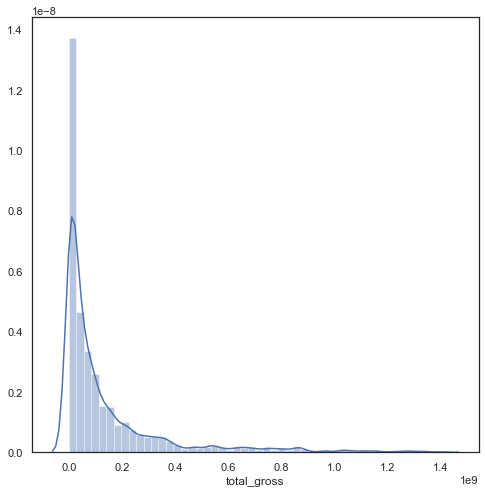

In [151]:
plotdf = df2[['genre', 'total_gross']]
plotdf = plotdf.reset_index()

genre_list = df1.genre.unique()
total_dict= {}
for genre_type in genre_list: 
    total_dict[genre_type] = df2.loc[df2.genre == genre_type][['tconst', 'total_gross', 'genre']]
g = total_dict[genre_list[4]]['total_gross']
y=g.tolist()
# print(len(y))
# print(y)
#plt.hist(y, bins = 20)
# plt.title(genre_list[4])
new_fig = plt.figure(figsize=(8,8))

sns.distplot(plotdf['total_gross'], bins =50, kde=True)
# sns.distplot(total_dict[genre_list[5]]['total_gross'], bins =50, norm_hist=1 )
# sns.distplot(total_dict[genre_list[6]]['total_gross'], bins =50, norm_hist=1 )

In [88]:
df1.groupby('genre').mean()

AttributeError: 'NoneType' object has no attribute 'groupby'

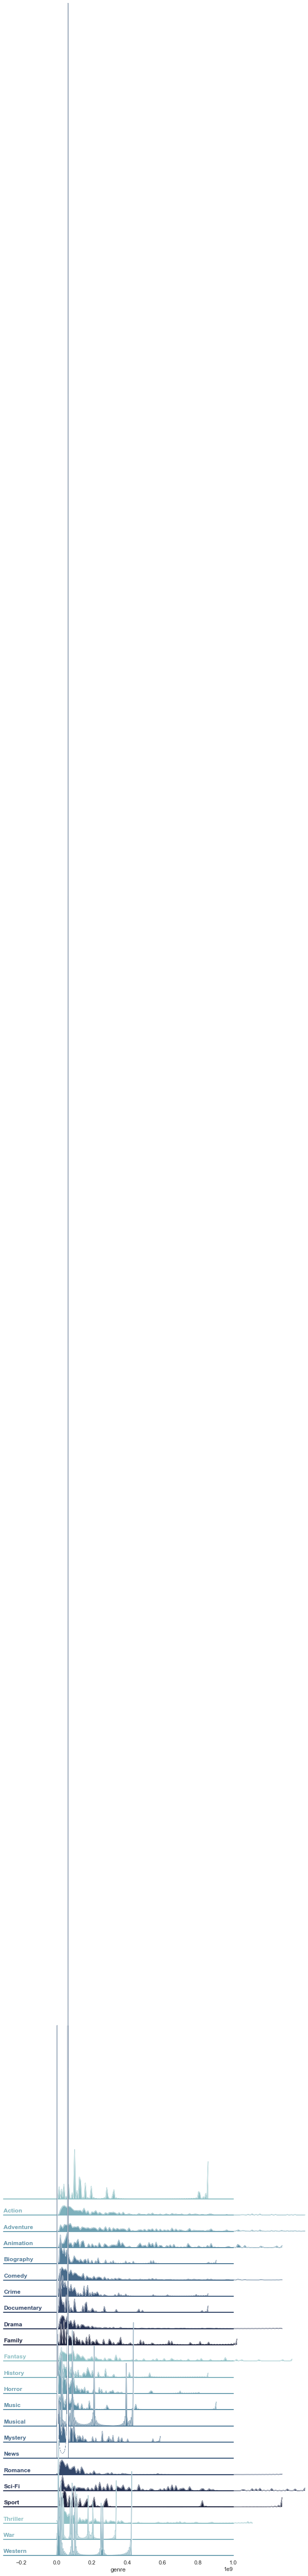

In [150]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
# rs = np.random.RandomState(1979)
# x = y
# print(x)
# g = np.tile(list("ABCDEFGHIJ"), 50)

# df = pd.DataFrame(dict(x=x, g=g))

# m = df.g.map(ord)

# df["x"] += m

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(plotdf, row="genre", hue="genre", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "total_gross", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, "total_gross", clip_on=False, color="w", lw=.5, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "genre")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)
g.set(ylim=(0, .00000001))
g.set(xlim=(-300000000, 1000000000))

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)


C:\Users\kyled\anaconda3\lib\site-packages\seaborn\axisgrid.py:861: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout()
C:\Users\kyled\anaconda3\lib\site-packages\seaborn\axisgrid.py:861: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout()


,x,g
0,64.038123,A
1,66.147050,B
2,66.370011,C
3,68.791019,D
4,70.583534,E


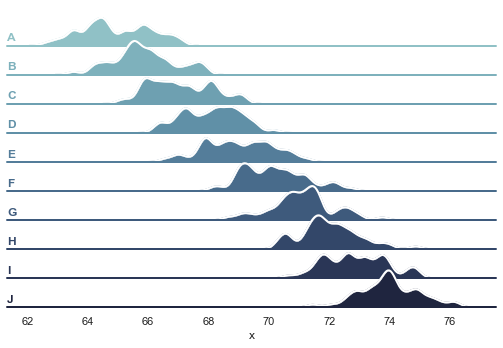

In [128]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
rs = np.random.RandomState(1979)
x = rs.randn(500)
g = np.tile(list("ABCDEFGHIJ"), 50)
df = pd.DataFrame(dict(x=x, g=g))
m = df.g.map(ord)
df["x"] += m

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "x")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)
df.head()

In [ ]:
SELECT *
FROM movies.imdb_title_basics itb
JOIN movies.bom_movie_gross bmg
ON itb.primary_title = bmg.title
JOIN movies.tn_movie_budgets tmb
ON tmb.movie = bmg.titleimdb_title_akas

In [ ]:
gb_genre=(df_genre_f.groupby(['genre']).mean())
print(len(gb_genre))
xvals = list(range(1, len(gb_genre)+1))
#print(xvals)
yvals = gb_genre['roi'].values
#print(yvals)
labels = gb_genre.index
#print(labels)
plt.figure(figsize = (10,3))
genre_plot = sns.barplot(x=labels, y=yvals, orient = 'v')
genre_plot.set_xticklabels(genre_plot.get_xticklabels(), rotation=90, horizontalalignment='center')
plt.xlabel('Genre')
plt.ylabel('ROI')
plt.title('Mean ROI per Genre')